In [46]:
import torch
import torch.nn as nn
from torchtext import data, datasets
from torchtext.vocab import Vocab
from collections import Counter
import random

# Same seed as Part 1
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)



In [47]:

#load previously done up glove embeddings and vocab

enhanced_embeddings = torch.load('enhanced_embeddings.pt')
vocab_state = torch.load('vocab_state.pt', weights_only=False)

vocab_size_part1, embedding_dim = enhanced_embeddings.shape
print(f"  Enhanced embeddings loaded: {enhanced_embeddings.shape}")
print(f"  Vocabulary state loaded: {vocab_state['vocab_size']} words")


# IMPORTANT : lower=True to match part 1 vocabulary
TEXT = data.Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    include_lengths=True,
    lower=True 
)

LABEL = data.LabelField()

#same as part1
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)
train_data, val_data = train_data.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f"  Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# Create vocab object with same specials as Part 1
TEXT.vocab = Vocab(
    Counter(),
    specials=['<unk>', '<pad>'],
    specials_first=True
)

# override with Part 1's GloVe vocabulary (lowercase)
TEXT.vocab.stoi = vocab_state['stoi']
TEXT.vocab.itos = vocab_state['itos']
TEXT.vocab.vectors = enhanced_embeddings

# build label vocab normally
LABEL.build_vocab(train_data)

print(f"  Vocabulary size: {len(TEXT.vocab)} (lowercase)")
print(f"  Number of classes: {len(LABEL.vocab)}")
print(f"  Label classes: {LABEL.vocab.itos}")

# verify that the vocab matches 
assert len(TEXT.vocab) == vocab_state['vocab_size'], \
    f"Part 1: {vocab_state['vocab_size']}, Part 2: {len(TEXT.vocab)}"
assert enhanced_embeddings.shape[0] == len(TEXT.vocab), \
    f"Embeddings: {enhanced_embeddings.shape[0]}, Vocab: {len(TEXT.vocab)}"

print(f"\nVocabulary matches Part 1 glove vocab")


PAD_IDX = TEXT.vocab.stoi['<pad>']
OUTPUT_DIM = len(LABEL.vocab)
print(f"  Padding index: {PAD_IDX}")

## create data iterations 
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    device=device
)

print(f"  Device: {device}")
print(f"  Batch size: {BATCH_SIZE}")



  Enhanced embeddings loaded: torch.Size([7435, 300])
  Vocabulary state loaded: 7435 words
  Train: 4362, Val: 1090, Test: 500
  Vocabulary size: 7435 (lowercase)
  Number of classes: 6
  Label classes: ['HUM', 'ENTY', 'DESC', 'NUM', 'LOC', 'ABBR']

Vocabulary matches Part 1 glove vocab
  Padding index: 1
  Device: cpu
  Batch size: 64


In [48]:

 #defining the rnn model
 
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
         # note: batch_first=False to match BucketIterator's output format
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=False)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, text):
        # text: [seq_len, batch_size] - from BucketIterator
        embedded = self.embedding(text)  # [seq_len, batch_size, emb_dim]
        
        # RNN output
        output, hidden = self.rnn(embedded)
        # output: [seq_len, batch_size, hidden_dim]
        # hidden: [1, batch_size, hidden_dim]
        
        # Take last hidden state (2d)
        # hidden = hidden[-1]  # [batch_size, hidden_dim]
        # out = self.dropout(hidden)
        
        # 2d method 2 mean pooling 
        # pooled = output.mean(dim=0)  # [batch_size, hidden_dim] 
        # out = self.dropout(pooled)
        
        # 2d method 3 max pooling
        pooled, _ = output.max(dim=0)  # [batch_size, hidden_dim]
        out = self.dropout(pooled)
        
        out = self.fc(out)
        
        return out

In [49]:
# initialize model
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_DIM = 300 #glove and word2vec same 
HIDDEN_DIM = 128
OUTPUT_DIM = len(LABEL.vocab)

model = SimpleRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)

# Load GloVe embeddings
model.embedding.weight.data.copy_(enhanced_embeddings)
model.embedding.weight.requires_grad = True  # Make trainable

model = model.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Configuration:")
print(f"  Vocabulary size: {VOCAB_SIZE:,}")
print(f"  Embedding dim: {EMBEDDING_DIM}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  Output dim: {OUTPUT_DIM}")
print(f"  Total parameters: {count_parameters(model):,}")
print(f"  Embeddings trainable: {model.embedding.weight.requires_grad}")


Model Configuration:
  Vocabulary size: 7,435
  Embedding dim: 300
  Hidden dim: 128
  Output dim: 6
  Total parameters: 2,286,314
  Embeddings trainable: True


In [50]:
# training parameters
LEARNING_RATE = 0.0008
N_EPOCHS = 60
PATIENCE = 5

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.00005) #updated in the loop later
criterion = nn.CrossEntropyLoss().to(device)

print(f"\nTraining Configuration:")
print(f"  Optimizer: Adam")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {N_EPOCHS}")
print(f"  Patience: {PATIENCE}")


Training Configuration:
  Optimizer: Adam
  Learning rate: 0.0008
  Batch size: 64
  Max epochs: 60
  Patience: 5


In [51]:
def train_epoch(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for batch in iterator:
        text, _ = batch.text  # text is [seq_len, batch_size]
        labels = batch.label  # labels is [batch_size]
        
        optimizer.zero_grad()
        
        predictions = model(text)
        loss = criterion(predictions, labels)
        
        # Calculate accuracy
        acc = (predictions.argmax(1) == labels).float().mean()
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def eval_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for batch in iterator:
            text, _ = batch.text
            labels = batch.label
            
            predictions = model(text)
            loss = criterion(predictions, labels)
            
            acc = (predictions.argmax(1) == labels).float().mean()
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [52]:
import numpy as np
import os
import shutil

# store runs in folder
os.makedirs('part2_glove_runs', exist_ok=True)

N_RUNS = 5  #independent 

# Store results from all runs
all_val_accs = []
all_test_accs = []
all_epochs = []


print(f"TRAINING {N_RUNS} INDEPENDENT RUNS")


for run in range(N_RUNS):
    print(f"\n{'='*60}")
    print(f"RUN {run+1}/{N_RUNS}")
    print(f"{'='*60}")
    
    # setting different seed for each run - 42 + runno
    torch.manual_seed(SEED + run)
    np.random.seed(SEED + run)
    
    # Create fresh model
    model = SimpleRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
    model.embedding.weight.data.copy_(enhanced_embeddings)
    model.embedding.weight.requires_grad = True
    model = model.to(device)
    
    # Fresh optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=5e-5)
    criterion = nn.CrossEntropyLoss().to(device)
    
    # Training storage
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    best_val_acc = 0
    patience_counter = 0
    
    print(f"\n{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}")
    print("-" * 60)
    
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion)
        val_loss, val_acc = eval_epoch(model, val_iterator, criterion)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"{epoch+1:<8} {train_loss:<12.4f} {train_acc:<12.4f} {val_loss:<12.4f} {val_acc:<12.4f}", end="")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save this run's best model
            torch.save(model.state_dict(), f'part2_glove_runs/best_model_run{run+1}.pt')
            print("Best")
        else:
            patience_counter += 1
            print()
        
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # load best model from this run and evaluate on test set
    model.load_state_dict(torch.load(f'part2_glove_runs/best_model_run{run+1}.pt'))
    test_loss, test_acc = eval_epoch(model, test_iterator, criterion)
    
    print(f"\nRun {run+1} Results:")
    print(f"  Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Epochs trained: {len(train_losses)}")
    
    # Store results
    all_val_accs.append(best_val_acc)
    all_test_accs.append(test_acc)
    all_epochs.append(len(train_losses))




mean_val_acc = np.mean(all_val_accs)
std_val_acc = np.std(all_val_accs)
mean_test_acc = np.mean(all_test_accs)
std_test_acc = np.std(all_test_accs)
mean_epochs = np.mean(all_epochs)
std_epochs = np.std(all_epochs)

print(f"\nValidation Accuracy:")
print(f"  Mean: {mean_val_acc:.4f}")
print(f"  Std: {std_val_acc:.4f}")
print(f"  Min: {min(all_val_accs):.4f}")
print(f"  Max: {max(all_val_accs):.4f}")

print(f"\nTest Accuracy:")
print(f"  Mean: {mean_test_acc:.4f}")
print(f"  Std: {std_test_acc:.4f}")
print(f"  Min: {min(all_test_accs):.4f}")
print(f"  Max: {max(all_test_accs):.4f}")

print(f"\nTraining Epochs:")
print(f"  Mean: {mean_epochs:.1f}")
print(f"  Std: {std_epochs:.1f}")

print(f"\nIndividual Run Results:")
print(f"{'Run':<6} {'Val Acc':<12} {'Test Acc':<12} {'Epochs':<8}")
print("-" * 40)
for i, (val_acc, test_acc, epochs) in enumerate(zip(all_val_accs, all_test_accs, all_epochs)):
    print(f"{i+1:<6} {val_acc:<12.4f} {test_acc:<12.4f} {epochs:<8}")

#select best run based on test accuracy
best_run_idx = np.argmax(all_test_accs)
best_val_acc = all_val_accs[best_run_idx]
best_test_acc = all_test_accs[best_run_idx]

print(f"\n{'='*60}")
print(f"BEST RUN: Run {best_run_idx + 1} (Highest Test Accuracy)")
print(f"{'='*60}")
print(f"Validation Accuracy: {best_val_acc:.4f}")
print(f"Test Accuracy: {best_test_acc:.4f}")
print(f"Epochs: {all_epochs[best_run_idx]}")

# copy best run's model to main directory
shutil.copy(f'part2_glove_runs/best_model_run{best_run_idx+1}.pt', 'best_rnn_model_glove.pt')
print(f"\n✓ Best model saved as 'best_rnn_model_glove.pt' (from Run {best_run_idx+1})")


print(f"\n{'='*60}")
print(f"Q2(a): FINAL MODEL CONFIGURATION")
print(f"{'='*60}")

print(f"\nModel Configuration:")
print(f"  Hidden dimension: {HIDDEN_DIM}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Optimizer: Adam")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Dropout: 0.5")
print(f"  Training epochs: {all_epochs[best_run_idx]}")

print(f"\nPerformance (Best Run):")
print(f"  Validation accuracy: {best_val_acc:.4f}")
print(f"  Test accuracy: {best_test_acc:.4f}")

print(f"\nPerformance (Mean ± Std over {N_RUNS} runs):")
print(f"  Validation accuracy: {mean_val_acc:.4f} ± {std_val_acc:.4f}")
print(f"  Test accuracy: {mean_test_acc:.4f} ± {std_test_acc:.4f}")
print(f"  Training epochs: {mean_epochs:.1f} ± {std_epochs:.1f}")

TRAINING 5 INDEPENDENT RUNS

RUN 1/5

Epoch    Train Loss   Train Acc    Val Loss     Val Acc     
------------------------------------------------------------
1        1.4438       0.4314       1.0846       0.6484      Best
2        0.8647       0.7166       0.6919       0.7856      Best
3        0.5745       0.8166       0.5259       0.8247      Best
4        0.4138       0.8663       0.4178       0.8655      Best
5        0.2980       0.9126       0.4570       0.8238      
6        0.1994       0.9432       0.3680       0.8663      Best
7        0.1382       0.9642       0.3571       0.8828      Best
8        0.0951       0.9762       0.3611       0.8898      Best
9        0.0755       0.9794       0.3896       0.8472      
10       0.0598       0.9846       0.3720       0.8915      Best
11       0.0463       0.9871       0.3983       0.8880      
12       0.0240       0.9966       0.5951       0.8394      
13       0.0202       0.9977       0.6596       0.8299      
14       0.0299

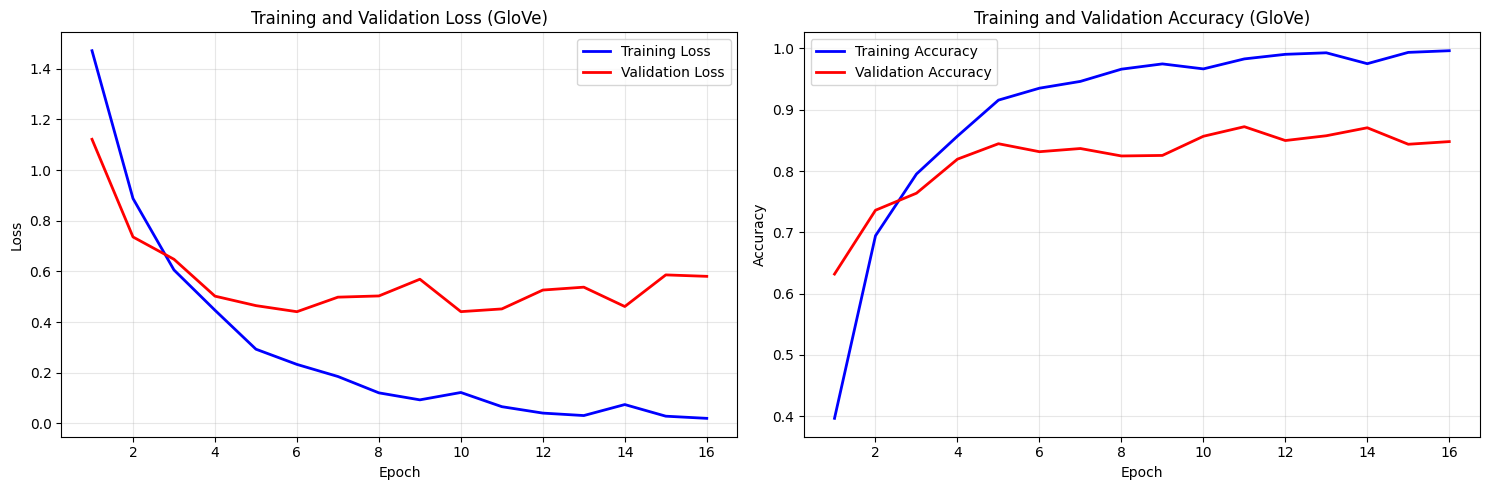

In [53]:
# qn 2c - plots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(train_losses) + 1)

# loss
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss (GloVe)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# acc
ax2.plot(epochs_range, train_accs, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy (GloVe)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rnn_training_curves_glove.png', dpi=300, bbox_inches='tight')
plt.show()

Learning Progress: Training loss decreases smoothly from 1.5 to near 0.0 while training accuracy reaches ~100%, demonstrating effective optimization. However, validation loss remains volatile (0.4-0.6 range) and validation accuracy plateaus at 83-87% after epoch 4, creating a 15% train-validation gap that indicates overfitting.  

Overfitting Evidence: The divergence between training and validation curves after epoch 4 shows the model memorizes training patterns rather than learning generalizable features. Validation loss fluctuates significantly rather than decreasing, while training loss continues dropping, showing some overfitting

Causes and Implications: The validation instability stems from the small validation set (1,090 samples) and class imbalance (ABBR: ~10 samples vs DESC: ~300). Early stopping at epoch 16 appropriately prevented further overfitting. The simple RNN architecture's limitations suggest more sophisticated models (LSTM/GRU) may generalize better.  



Classification Report:
              precision    recall  f1-score   support

         HUM     0.9492    0.8615    0.9032        65
        ENTY     0.8987    0.7553    0.8208        94
        DESC     0.7907    0.9855    0.8774       138
         NUM     0.9806    0.8938    0.9352       113
         LOC     0.8889    0.8889    0.8889        81
        ABBR     1.0000    0.6667    0.8000         9

    accuracy                         0.8840       500
   macro avg     0.9180    0.8420    0.8709       500
weighted avg     0.8942    0.8840    0.8837       500



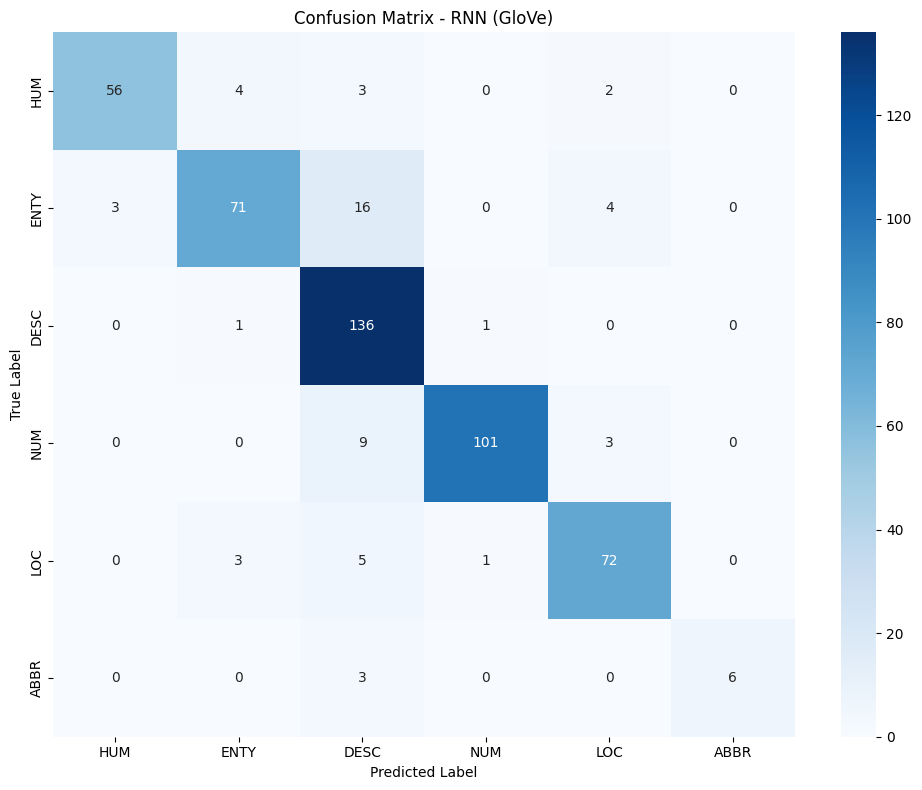


TOPIC-WISE ACCURACY:
HUM        Accuracy: 0.8615 (65 samples)
ENTY       Accuracy: 0.7553 (94 samples)
DESC       Accuracy: 0.9855 (138 samples)
NUM        Accuracy: 0.8938 (113 samples)
LOC        Accuracy: 0.8889 (81 samples)
ABBR       Accuracy: 0.6667 (9 samples)


In [54]:
#qn 2e


def get_predictions(model, iterator):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in iterator:
            text, _ = batch.text
            labels = batch.label
            
            predictions = model(text)
            all_preds.extend(predictions.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

preds, labels = get_predictions(model, test_iterator)

# Classification report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=LABEL.vocab.itos, digits=4))

# Confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABEL.vocab.itos,
            yticklabels=LABEL.vocab.itos)
plt.title('Confusion Matrix - RNN (GloVe)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_rnn_glove.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-topic accuracy
print("\n" + "="*60)
print("TOPIC-WISE ACCURACY:")
print("="*60)

for i, topic in enumerate(LABEL.vocab.itos):
    topic_mask = labels == i
    if topic_mask.sum() > 0:
        topic_acc = (preds[topic_mask] == labels[topic_mask]).mean()
        topic_count = topic_mask.sum()
        print(f"{topic:<10} Accuracy: {topic_acc:.4f} ({topic_count} samples)")

Performance Distribution: Topic-wise accuracy varies significantly: DESC (98.55%), NUM (89.38%), LOC (88.89%), HUM (86.15%), ENTY (75.53%), and ABBR (66.67%). This 32-percentage-point gap indicates uneven learning, with the model excelling at well-represented categories but struggling with rare or ambiguous ones.  

Class Imbalance Impact: Performance correlates with data availability. DESC (138 samples) has distinctive patterns ("what/why/how" explanations) enabling near-perfect accuracy, while ABBR (9 samples) suffers from severe data scarcity with 33% error rate. NUM and LOC perform well (~89%) due to clear lexical markers ("how many," geographical terms).  

Semantic Confusion: The confusion matrix shows systematic errors between overlapping categories. ENTY underperforms (75.53%) because "What is X?" questions overlap with DESC, causing 16 misclassifications. HUM (86.15%) confuses with ENTY when asking about roles. These errors indicate the simple RNN cannot distinguish subtle syntactic differences without attention mechanisms or bidirectional context.